# Compare results from Galaxy Builder to Hart (2017)

Ross Hart fit a relationship between GZ2 debiased morpholocal votes and the length-weighted, dominant chirality only pitch angle reported by [SpArcFiRe](http://sparcfire.ics.uci.edu/). In this notebook we compare the length-weighted galaxy builder pitch angles to that relationship.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.stats as st
from tqdm import tqdm
from IPython.display import display
import lib.galaxy_utilities as gu
from tqdm import tqdm

Load in a list of available subject ids and the [GZ2 debiased vote counts](https://data.galaxyzoo.org/).

In [3]:
from gzbuilder_analysis import load_aggregation_results
agg_results = load_aggregation_results('output_files/aggregation_results')

In [4]:
df_gz2 = pd.read_csv(
  '../source_files/gz2_hart16.csv'
).set_index('dr7objid')

Define some helper functions for feature extraction

In [5]:
def get_nsaid(sid):
    return np.int64(gu.metadata['NSA id'].loc[sid])

def get_dr7objid(sid):
    return np.int64(gu.metadata['SDSS dr7 id'].loc[sid])

def hart_wavg(gal):
    return (np.hstack((
        gal['t10_arms_winding_a28_tight_debiased'],
        gal['t10_arms_winding_a29_medium_debiased'],
        gal['t10_arms_winding_a30_loose_debiased'],
    )) * (np.arange(3) + 1)).sum()

def hart_mavg(gal, t='debiased'):
    p = np.hstack((
        gal[f't11_arms_number_a31_1_{t}'],
        gal[f't11_arms_number_a32_2_{t}'],
        gal[f't11_arms_number_a33_3_{t}'],
        gal[f't11_arms_number_a34_4_{t}'],
        gal[f't11_arms_number_a36_more_than_4_{t}'],
    ))
    return (p / p.sum() * (np.arange(5) + 1)).sum()

def hart_mmax(gal, t='debiased'):
    return np.argmax((
        gal[f't11_arms_number_a37_cant_tell_{t}'],
        gal[f't11_arms_number_a31_1_{t}'],
        gal[f't11_arms_number_a32_2_{t}'],
        gal[f't11_arms_number_a33_3_{t}'],
        gal[f't11_arms_number_a34_4_{t}'],
        gal[f't11_arms_number_a36_more_than_4_{t}'],
    ))

def hart_pa(wavg, mavg):
    return 6.37 * wavg + 1.30 * mavg + 4.34

def get_hart_params(row):
    gal = df_gz2.loc[row['DR7OBJID']]
    wavg, mavg, mmax = hart_wavg(gal), hart_mavg(gal), hart_mmax(gal, 'debiased')
    if wavg == 0.0 or mavg == 0.0:
        pa = np.nan
    else:
        pa = hart_pa(wavg, mavg)
    return pd.Series(dict(hart_pa=pa, wavg=wavg, mavg=mavg, mmax=mmax))


SPIRAL_COUNT_COLS = [i for i in df_gz2.columns if 'arms_number' in i and 'count' in i]
def get_count_columns(row):
    return df_gz2[SPIRAL_COUNT_COLS].loc[row['DR7OBJID']]

Generate a DataFrame containing GZB pitch angles, NSA IDs, SDSS DR7 IDs, and use it to calculate Hart (2017) pitch angles from the GZ2 data export. Then add a column with the pitch angle difference and an error approximation.

In [6]:
hart_df = pd.concat((
    agg_results.index.to_series().apply(get_nsaid).rename('NSAID'),
    agg_results.index.to_series().apply(get_dr7objid).rename('DR7OBJID')
), axis=1).apply(get_hart_params, axis=1)

In [7]:
gzb_pa_df = agg_results.apply(
    lambda a: pd.Series(
        a.spiral_pipeline.get_pitch_angle(a.spiral_arms),
        index=('pa', 'sigma_pa'),
    )
)
pa_spiral_df = pd.concat((hart_df.hart_pa, gzb_pa_df), axis=1)

What do the distributions of pitch angles look like? Can the difference between the two be put down to error?

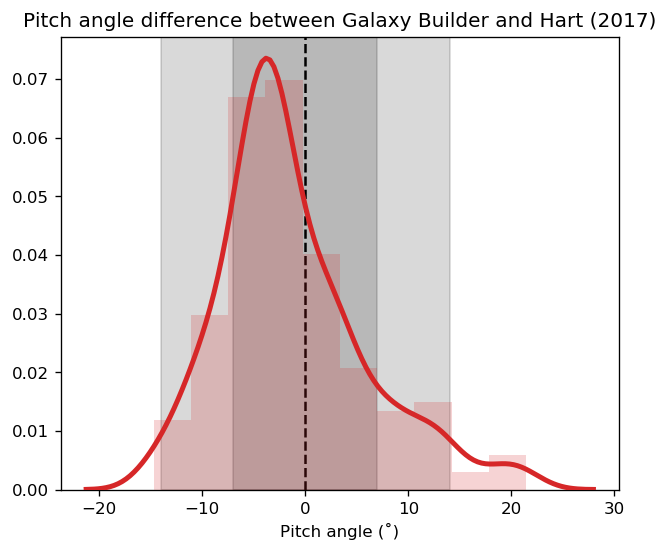

In [8]:
plt.figure(figsize=(6, 5), dpi=120)
plt.title('Pitch angle difference between Galaxy Builder and Hart (2017)')
pa_diff = (pa_spiral_df.pa - pa_spiral_df.hart_pa).dropna()
plt.hist(pa_diff, density=True, alpha=0.2, zorder=10, color='C3')
sns.kdeplot(pa_diff, lw=3, zorder=10, color='C3')
ylims = plt.gca().get_ylim()
plt.fill_betweenx(np.linspace(0, ylims[1]), -7, 7, color='k', alpha=0.15, zorder=1)
plt.fill_betweenx(np.linspace(0, ylims[1]), -14, 14, color='k', alpha=0.15, zorder=1)
plt.vlines(0, *ylims, linestyles='dashed')
plt.ylim(*ylims)
plt.xlabel('Pitch angle (˚)')
plt.savefig(
  'method-paper-plots/gzb-hart-comparison.pdf',
  bbox_inches='tight'
);

## Comparison with number of spirals:

Using models drawn by volunteers:

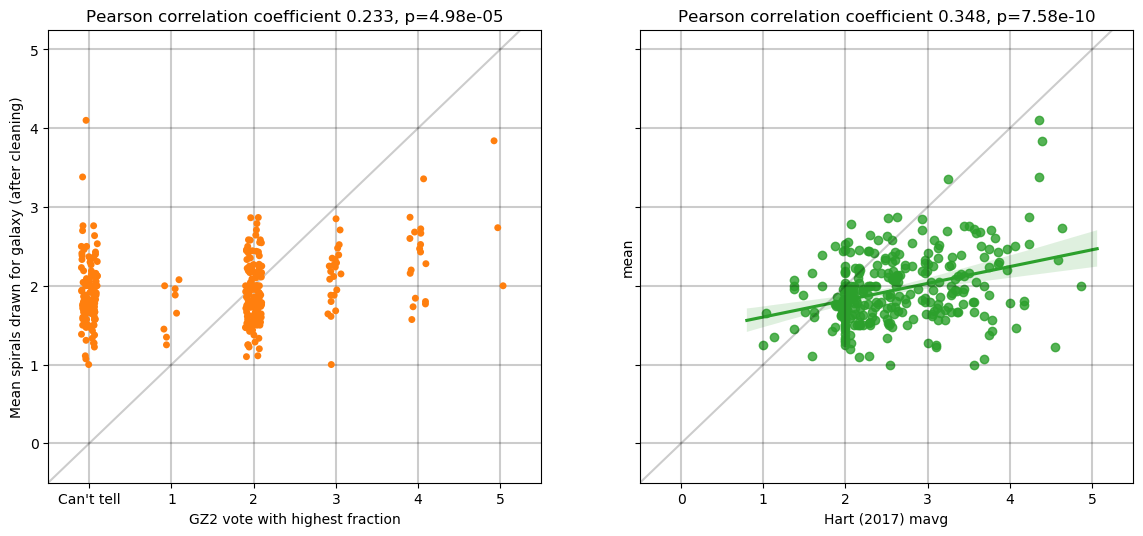

In [9]:
n_spirals_in_cls = agg_results.apply(
    lambda a: a.input_models.apply(
        lambda b: len(b['spiral']),
    ).reset_index(drop=True)
)
spiral_clf_df = pd.concat((
    n_spirals_in_cls.replace(0, np.nan).T.describe().T,
    hart_df[['mmax', 'mavg']],
), axis=1)
f, ax = plt.subplots(ncols=2, sharey=True, figsize=(14, 6), dpi=100)
plt.sca(ax[0])
sns.stripplot('mmax', 'mean', data=spiral_clf_df, color='C1')
corr = st.pearsonr(*spiral_clf_df[['mmax', 'mean']].dropna().values.T)
plt.xticks(np.arange(20), ['Can\'t tell', *np.arange(1, 20)])
plt.title('Pearson correlation coefficient {:.3f}, p={:.2e}'.format(*corr));
plt.xlabel('GZ2 vote with highest fraction')
plt.ylabel('Mean spirals drawn for galaxy (after cleaning)')

plt.sca(ax[1])
# spiral_clf_df.plot.scatter('mmax', 'mean', ax=plt.gca(), color='C1')
sns.regplot('mavg', 'mean', spiral_clf_df, color='C2', ax=ax[1])
# spiral_clf_df.plot.scatter('mavg', 'mean', ax=plt.gca(), color='C2')
corr = st.pearsonr(*spiral_clf_df[['mavg', 'mean']].dropna().values.T)
plt.title('Pearson correlation coefficient {:.3f}, p={:.2e}'.format(*corr));
plt.xlabel('Hart (2017) mavg')
for a in ax:
    plt.sca(a)
    for i in (0, 1, 2, 3, 4, 5):    
        plt.axvline(i, c='k', alpha=0.2)
        plt.axhline(i, c='k', alpha=0.2)
    plt.ylim(-0.5)
    plt.xlim(-0.5, 5.5)
    plt.gca().add_line(plt.Line2D(*[(-1E2, 1E2)]*2, c='k', alpha=0.2))

Using aggregated models:

In [10]:
n_agg_spirals = agg_results.apply(
    lambda a: len(a.spiral_arms)
).rename('m_gzb')

In [11]:
n_spiral_df = pd.concat((hart_df.mmax, hart_df.mavg, n_agg_spirals), axis=1)
display(n_spiral_df.corr('spearman'))
st.spearmanr(*n_spiral_df[['mmax', 'm_gzb']].dropna().values.T)

,mmax,mavg,m_gzb
mmax,1.000000,-0.006755,0.311754
mavg,-0.006755,1.000000,0.123267
m_gzb,0.311754,0.123267,1.000000


SpearmanrResult(correlation=0.31175435864122286, pvalue=4.300236379176542e-08)

(-0.5, 4.5)

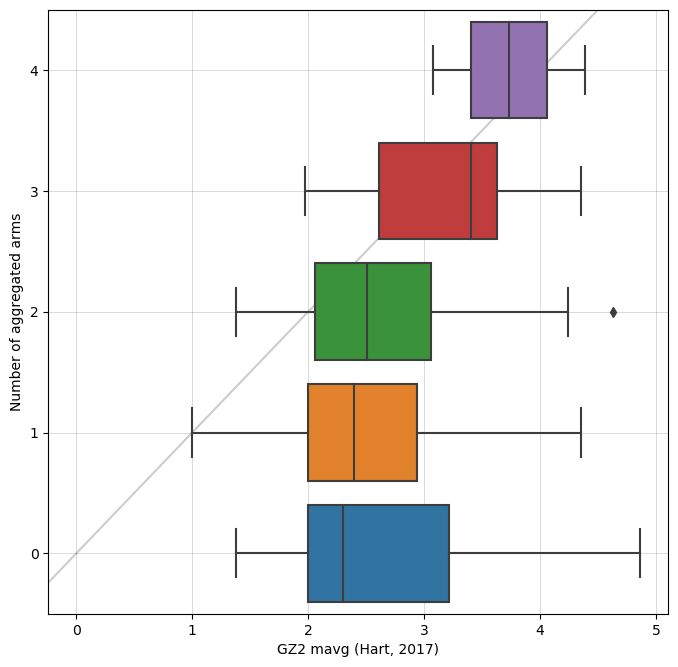

In [12]:
plt.figure(figsize=(8, 8), dpi=100)
sns.boxplot(x='mavg', y='m_gzb', data=n_spiral_df, orient='h')
for i in (0, 1, 2, 3, 4, 5):
    plt.axvline(i, c='k', alpha=0.2, lw=0.5, zorder=0)
    plt.axhline(i, c='k', alpha=0.2, lw=0.5, zorder=0)
plt.gca().add_line(plt.Line2D(*[(-1E2, 1E2)]*2, c='k', alpha=0.2, zorder=0))
plt.xlabel('GZ2 mavg (Hart, 2017)')
plt.ylabel('Number of aggregated arms')
plt.ylim(-0.5, 4.5)

We can also make direct use of the vote counts to properly model the uncertainty present in each GZ2 classifcation, in a more rigorous manner than the *mavg* proposed by Hart (2017).

>*For each classification of a galaxy with $n_\mathrm{gzb}$ aggregate arms, add $1/N_\mathrm{cls}$ to the area of the circle at $(C, n_\mathrm{gzb})$, where $N_\mathrm{cls}$ is the total number of times that the "number of arms" question was answered for that galaxy, and C is the value of the classification.*

i.e. (maybe)
$$
A_{i, j} = \sum_{k}^{N_g}\frac{1}{M_k}\sum_{m}^{M_k}
\begin{cases}
  1,&\ \mathrm{if}\ n_k = i\ \mathrm{and}\ C_{k, m} = j\\
  0,&\ \mathrm{otherwise}
\end{cases}
$$
Where $n_k$ is the number of aggrage arms for galaxy $k$ (out of $N_g$ galaxies), $C_{k, m}$ is the $m$-th answer for galaxy $k$, out of $M_k$ answers. $\delta$ is the Dirac delta function.

In [13]:
gz2_count_df = pd.concat((
    agg_results.index.to_series().apply(get_nsaid).rename('NSAID'),
    agg_results.index.to_series().apply(get_dr7objid).rename('DR7OBJID')
), axis=1).apply(get_count_columns, axis=1).assign(m_gzb=n_agg_spirals)

In [14]:
areas = pd.DataFrame(
    index=np.unique(gz2_count_df.m_gzb),
    columns=gz2_count_df.drop(columns='m_gzb').columns
)
for j in areas.index:
    counts = gz2_count_df.query('m_gzb == @j').drop(columns='m_gzb')
    As = counts.sum(axis=0)
    areas.loc[j] = As / np.sum(As)

In [15]:
rename_dict = dict(
    t11_arms_number_a31_1_count=1,
    t11_arms_number_a32_2_count=2,
    t11_arms_number_a33_3_count=3,
    t11_arms_number_a34_4_count=4,
    t11_arms_number_a36_more_than_4_count=5,
    t11_arms_number_a37_cant_tell_count=0
)

areas_renamed = areas.rename(columns=rename_dict)

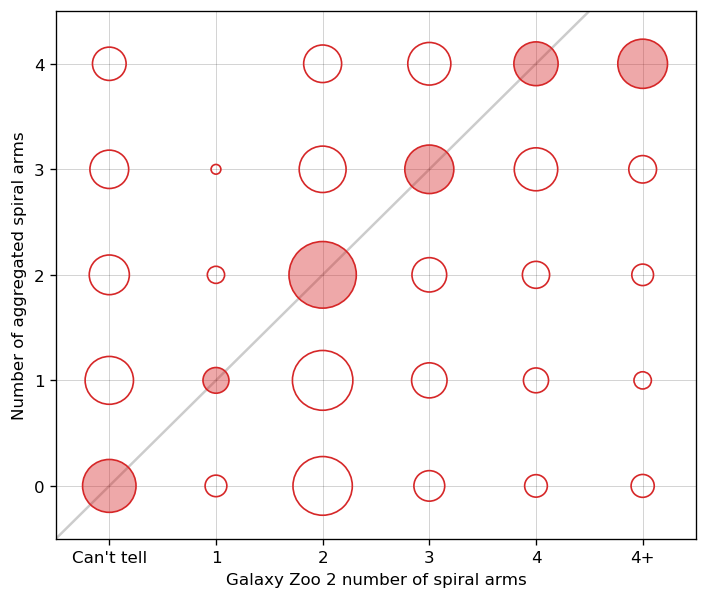

In [16]:
circ_norm = 1 / areas.max().max()
circ_scaling = circ_norm * 0.4

plt.figure(figsize=(6, 5.1), dpi=120)
for col in areas_renamed.columns:
    for row in areas_renamed.index:
        A = areas_renamed[col][row]
        r = np.sqrt(A / np.pi) * circ_scaling
        if r > 0:
            plt.gca().add_patch(
                Circle(
                    (col, row), r,
                    zorder=1, alpha=1,
                    fc='none', ec='C3'
                )
            )
            if A == areas_renamed[col].max():
                plt.gca().add_patch(
                    Circle((col, row), r, zorder=1, alpha=0.4, fc='C3')
                )
                
for i in (0, 1, 2, 3, 4, 5):
    plt.axvline(i, c='k', alpha=0.2, lw=0.5, zorder=0)
    plt.axhline(i, c='k', alpha=0.2, lw=0.5, zorder=0)
plt.gca().add_line(plt.Line2D(*[(-1E2, 1E2)]*2, c='k', alpha=0.2, zorder=0))
plt.xticks(np.arange(6), ['Can\'t tell', *np.arange(1, 5), '4+'])
plt.xlim(-0.5, 5.5)
plt.ylim(-0.5, 4.5)
plt.xlabel('Galaxy Zoo 2 number of spiral arms')
plt.ylabel('Number of aggregated spiral arms')
plt.tight_layout()
plt.savefig('method-paper-plots/spiral-number-vs-gz2.pdf', bbox_inches='tight')

We see a similar relationship if we use the most likely vote too (note this plot has been column-normalized):

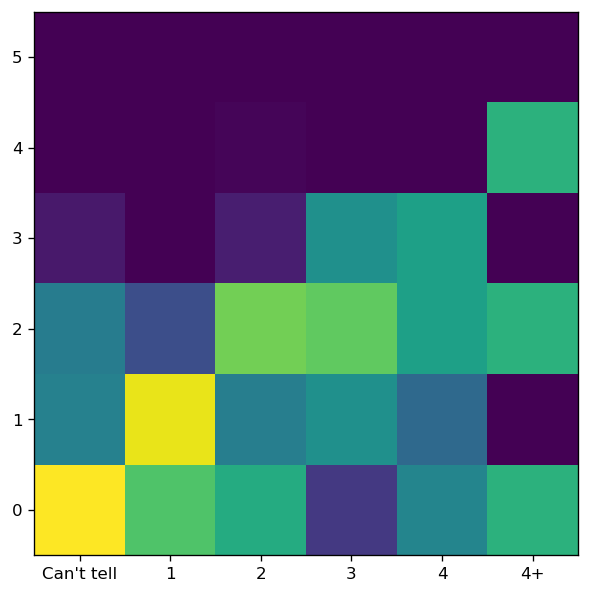

In [17]:
mx_areas = np.zeros((6, 6))
for i in range(mx_areas.shape[0]):
    for j in range(mx_areas.shape[1]):
        mx_areas[i, j] = (
            np.sum((n_agg_spirals == i)&(hart_df.mmax == j))
            / (hart_df.mmax == j).sum()
        )

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(mx_areas, origin='lower')
plt.xticks(range(6), ['Can\'t tell', *np.arange(1, 5), '4+']);

Cases where people said 2 spirals and we got more:
- 20902009, merging failed
- 20902070, very blurry two or three armed galaxy (we got 3)
- 21096867, one of the spirals has been split into two sections (I see three arms)
- 21096878, as above